# ResNet'in Keras'ta Uygulanması

Daha derin sinir ağlarının eğitilmesi daha zordur. Residual learning, daha önce kullanılanlardan önemli ölçüde daha derin olan ağların eğitimini kolaylaştırmak için tanıtıldı. ResNet, başvurulmayan işlevleri öğrenmek yerine, katman girişlerini referans alarak residual fonksiyonları öğrenmek olarak katmanları  yeniden biçimlendirir. ImageNet veri kümesinde bu yöntem, 152 katman derinliğine sahip residual ağlarla değerlendirildi - VGG ağlarından 8 kat daha derin, ancak hala daha düşük karmaşıklığa sahip. Bu residual ağlardan oluşan topluluk, ImageNet test setinde % 3,57 hata elde etti. Bu sonuç ILSVRC 2015 sınıflandırma yarışmasında 1. oldu. </br>

<li>K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. arXiv preprintarXiv:1512.03385,2015.</li>

Residual, Daha sonraki davranışları etkileyen içsel bir deneyim veya faaliyet sonrası etki olarak tanımlanabilir.</br>

Keras'a ResNet uygulayabilmek için residual blok kavramının kullanılması gerekir. Bu, aslında bir "skip connection" (residual connection) olan iki dense katmandır. </br>

<img src='resnet.png'/>
<center>Skip Layer(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Residual bloklar tipik olarak evrişimli sinir ağları (CNN'ler) ile kullanılır. Bu, CNN'ler üzerinde çok derin sinir ağlarının oluşturulmasına izin verir. </br>

<img src='resnet2.png'/>
<center>Çeşitli ResNet Örnekleri(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

## Keras Sequence vs Functional Model API

Şimdiye kadar sinir ağlarını oluştururken Sequence sınıfı kullanılmıştır. ResNet ile karşımıza farklı bir sınıf olan Model gelmiştir. Keras'ta bir NN oluşturmanın iki yolu bulunmaktadır.

<li><b>Sequential :</b> Bilgi akışının girdiden çıktıya kadar basit bir sıra olduğu çoğu modeli destekleyen Keras için basitleştirilmiş bir interface'dir.</li>

<li><b>Keras Functional API:</b> Sinir ağlarının yeniden kullanılan katmanlardan, çoklu giriş katmanlarından oluşturulmasına olanak tanıyan ve kendi tekrarlayan bağlantılarınızı oluşturmayı destekleyen daha karmaşık bir interface'dir.</li>

# CIFAR VeriSeti

In [1]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train boyutu = {X_train.shape}')
print(f'y_train boyutu = {y_train.shape}')
print('---------------------------------------')
print(f'X_test boyutu = {X_test.shape}')
print(f'y_test boyutu = {y_test.shape}')

170500096/170498071 [==============================] - 103s 1us/step
X_train boyutu = (50000, 32, 32, 3)
y_train boyutu = (50000, 1)
---------------------------------------
X_test boyutu = (10000, 32, 32, 3)
y_test boyutu = (10000, 1)


<Figure size 432x288 with 0 Axes>

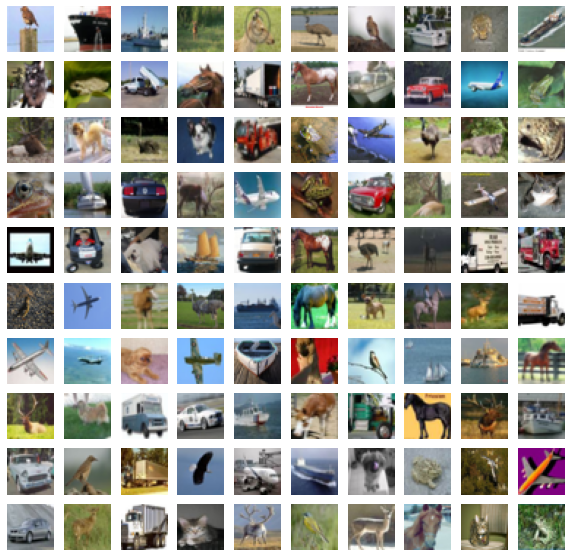

In [4]:
# random image representation

import numpy as np
import matplotlib.pyplot as plt

ROWS = 10

X = X_train.astype('uint8')

plt.clf()

fig, axes = plt.subplots(ROWS, ROWS, figsize=(10, 10))

for i in range(ROWS):
    for j in range(ROWS):
        rnd = np.random.choice(range(len(X)))
        axes[i][j].set_axis_off()
        axes[i][j].imshow(X[rnd:rnd+1][0])

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

BATCH_SIZE = 32
EPOCHS = 200
USE_AUGMENTATION = True
NUM_CLASSES = np.unique(y_train).shape[0]
COLORS = X_train.shape[3]

# Piksel ortalamasının çıkarılması doğruluğu artırır
SUBTRACT_PIXEL_MEAN = True

# ResNet V1
VERSION = 1

# Sağlanan model parametresinden hesaplanan DEPTH n

if VERSION == 1:
    DEPTH = COLORS * 6 + 2
elif VERSION == 2:
    DEPTH = COLORS * 9 + 2

# Öğrenme oranı düşüş sürecini uygulayan fonksiyon

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e -3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    
    print('Learning Rate = ', lr)
    return lr

# Aşağıdaki kod bir ResNet bloğunu oluşturur. Bu, atlama bağlantılı iki evrişimli katman içerir. 
# ResNet'in hem V1 hem de V2'si bu tür katmanı kullanır.

def resnet_layer(inputs, num_filters=16, kernel_size=3, stride=1, activation='relu',
                batch_normalization=True, conv_first=True):
    # Arguments
        
        # inputs (tensor): giriş görüntüsünden veya önceki katmandan gelen giriş tensörü
        # num_filters (int): Conv2D filtre sayısı
        # kernel_size (int):Conv2D kare kernel boyutları
        # strides (int): Conv2D kare stride boyutları
        # activation (str): aktivasyon fonksiyonu ismi
        # batch_normalization :(bool) batch normalization'ın dahil edilip edilmeyeceği
        # conv_first (bool) : conv-bn-activation (True) veya conv-bn-activation (False)
    
    # Returns
        # x (tensor) : sonraki katmana girdi olan tensör
    
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same',
                 kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x=conv(x)
    
    return x


        